In [1]:
import json
import re
import collections
import numpy as np
import multiprocessing

import pandas as pd

from pyagender import PyAgender
from io import BytesIO
from PIL import Image
import requests

import cv2

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In this notebook we get the age and gender based of the picture of a person.
For this we consider only a subset of all images, those containing people that have a name associated with them.

we do the following processing:

1. get ids for photos where only one person is in the image
2. get list of images associated with on person
3. use py-agender to get the age and gender

finally we do some evaluation

### 1. get ids of photos where only one person is in the image

In [2]:
df = pd.read_pickle('named_subject.pkl')

In [3]:
df

,descriptor,id,19e,Portraits,caricature,subject_name,named_subject
0,"Auguez, Mathilde (1868-1955) -- Portraits",https://gallica.bnf.fr/ark:/12148/btv1b53168872x,False,True,False,"[Auguez, Mathilde]","Auguez, Mathilde"
2,"Auguez, Mathilde (1868-1955) -- Portraits",https://gallica.bnf.fr/ark:/12148/btv1b531688701,False,True,False,"[Auguez, Mathilde]","Auguez, Mathilde"
4,"Bruant, Aristide (1851-1925) -- Portraits",https://gallica.bnf.fr/ark:/12148/btv1b53171770j,False,True,False,"[Bruant, Aristide]","Bruant, Aristide"
6,"Auguez, Mathilde (1868-1955) -- Portraits",https://gallica.bnf.fr/ark:/12148/btv1b53168873c,False,True,False,"[Auguez, Mathilde]","Auguez, Mathilde"
8,"Brasseur, Albert (1862-1932) -- Portraits",https://gallica.bnf.fr/ark:/12148/btv1b531651494,False,True,False,"[Brasseur, Albert]","Brasseur, Albert"
...,...,...,...,...,...,...,...
9589,Cham (1818-1879) -- Oeuvres -- Dessin,https://gallica.bnf.fr/ark:/12148/btv1b531189073,False,False,False,[Cham],Cham
9980,"Carvalho, Léon (1825-1897) -- Tombes",https://gallica.bnf.fr/ark:/12148/btv1b53117431d,False,False,False,"[Carvalho, Léon]","Carvalho, Léon"
11180,"Sand, George (1804-1876) -- Statues",https://gallica.bnf.fr/ark:/12148/btv1b530916961,False,False,False,"[Sand, George]","Sand, George"
11795,"Sand, George (1804-1876) -- Statues",https://gallica.bnf.fr/ark:/12148/btv1b53091695k,False,False,False,"[Sand, George]","Sand, George"


In [4]:
person_per_image = df.groupby('id').named_subject.count()

In [5]:
individual_portraits = person_per_image[person_per_image == 1].index

How many pictures do we have of one person?

In [6]:
df[df.id.isin(individual_portraits)].groupby('named_subject').id.count()

named_subject
Abbatucci, Séverin               5
Abbott, Emma                    50
Abbéma, Louise                  12
Abney, William de Wiveleslie     3
Abott, Bessie                    1
                                ..
Édouard VII                     25
Énault, Louis                    1
Éon, Charles de Beaumont d'      1
Étex, Antoine                    2
Étiévant, Henri                  1
Name: id, Length: 1903, dtype: int64

12 people don't have portraits. That's okay, we focus on the people that do.

In [7]:
df[df.id.isin(individual_portraits) & df.Portraits].groupby('named_subject').id.count()

named_subject
Abbatucci, Séverin               5
Abbott, Emma                    50
Abbéma, Louise                  12
Abney, William de Wiveleslie     3
Abott, Bessie                    1
                                ..
Édouard VII                     25
Énault, Louis                    1
Éon, Charles de Beaumont d'      1
Étex, Antoine                    2
Étiévant, Henri                  1
Name: id, Length: 1886, dtype: int64

### 2. get list associated to person

In [8]:
personal_portrait_image = df[df.id.isin(individual_portraits) &\
                             df.Portraits].groupby('named_subject').apply(lambda x: x.id.tolist())
personal_portrait_image = personal_portrait_image.rename('id').reset_index()

In [9]:
personal_portrait_image

,named_subject,id
0,"Abbatucci, Séverin",[https://gallica.bnf.fr/ark:/12148/btv1b530716...
1,"Abbott, Emma",[https://gallica.bnf.fr/ark:/12148/btv1b531637...
2,"Abbéma, Louise",[https://gallica.bnf.fr/ark:/12148/btv1b530715...
3,"Abney, William de Wiveleslie",[https://gallica.bnf.fr/ark:/12148/btv1b531651...
4,"Abott, Bessie",[https://gallica.bnf.fr/ark:/12148/btv1b531175...
...,...,...
1881,Édouard VII,[https://gallica.bnf.fr/ark:/12148/btv1b530980...
1882,"Énault, Louis",[https://gallica.bnf.fr/ark:/12148/btv1b530653...
1883,"Éon, Charles de Beaumont d'",[https://gallica.bnf.fr/ark:/12148/btv1b530664...
1884,"Étex, Antoine",[https://gallica.bnf.fr/ark:/12148/btv1b531271...


In [10]:
agender = PyAgender() 

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


### 3. get age-gender lables 

the api not only gives us an age and gender estimate, but also the rectangle pointing to the face. We keep that as it can be used for the face map 

In [14]:
def get_image_from_download(doc):
    doc = '../humans_of_paris/app/static/img_full/' + doc.split('/')[-1]+'.png'
    img = Image.open(doc)
    img = np.array(img)
    return img

In [28]:
def get_image(doc):
    url = doc+'/f1.highres.jpg'
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    img = np.array(img)
    return img

def get_age_gender_estimates(image_docs):
    i = 0
    estimates = []
    
    #handle case where for one image of personn we can't get estimates
    while i < len(image_docs) and len(estimates) == 0:
        retries = 0
        try:
            img = get_image_from_download(image_docs[i])
        except:
            img = get_image(image_docs[i])
            
        
        while retries < 5 and len(estimates) == 0:
            estimates = agender.detect_genders_ages(img)
            retries += 1
        i = i+1
        
    if estimates:
        # use first estimate as it is most likely one
        result = estimates[0]
        result['number'] = len(estimates)
        result['id'] = image_docs[i-1]
        return result
    
    return {}

In [29]:
if True:
    age_gender_lables = personal_portrait_image.id.map(get_age_gender_estimates)  
    age_gender_lables = pd.DataFrame(age_gender_lables.tolist())
    age_gender_lables['name'] = personal_portrait_image.named_subject
    age_gender_lables.to_json('age_gender_labeles_2.json')

In [30]:
age_gender_lables.dropna()

,left,top,right,bottom,width,height,gender,age,number,id,name
0,57.0,45.0,291.0,279.0,234.0,234.0,0.103912,45.547640,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071608k,"Abbatucci, Séverin"
1,98.0,175.0,269.0,346.0,171.0,171.0,0.386506,41.677062,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53162238m,"Abbott, Emma"
2,82.0,73.0,253.0,244.0,171.0,171.0,0.134583,26.248534,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071525p,"Abbéma, Louise"
3,18.0,9.0,345.0,336.0,327.0,327.0,0.045598,46.299528,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53165139q,"Abney, William de Wiveleslie"
4,415.0,184.0,615.0,384.0,200.0,200.0,0.389818,27.194442,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53117510h,"Abott, Bessie"
...,...,...,...,...,...,...,...,...,...,...,...
1880,68.0,68.0,241.0,241.0,173.0,173.0,0.068460,58.135052,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530659938,trios
1881,76.0,93.0,218.0,235.0,142.0,142.0,0.049408,45.836890,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53098072j,Édouard VII
1882,94.0,72.0,232.0,210.0,138.0,138.0,0.028471,42.861130,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53065399p,"Énault, Louis"
1883,288.0,437.0,583.0,732.0,295.0,295.0,0.358721,26.078685,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530664193,"Éon, Charles de Beaumont d'"


In [13]:
age_gender_lables = pd.read_json('age_gender_labeles.json')

# evaluation of method


evaluation of algorithm itself is presented on wikipage of py-agender: https://github.com/yu4u/age-gender-estimation

In [14]:
age_gender_lables#.map(len).value_counts()

,left,top,right,bottom,width,height,gender,age,number,id,name
0,269.0,268.0,748.0,747.0,479.0,479.0,0.116277,47.741472,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071608k,"Abbatucci, Séverin"
1,433.0,316.0,580.0,463.0,147.0,147.0,0.585720,27.465579,2.0,https://gallica.bnf.fr/ark:/12148/btv1b531622212,"Abbott, Emma"
2,250.0,718.0,403.0,871.0,153.0,153.0,0.377803,40.358822,3.0,https://gallica.bnf.fr/ark:/12148/btv1b53071525p,"Abbéma, Louise"
3,155.0,134.0,872.0,851.0,717.0,717.0,0.104841,44.487285,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53165139q,"Abney, William de Wiveleslie"
4,415.0,184.0,615.0,384.0,200.0,200.0,0.389818,27.194442,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53117510h,"Abott, Bessie"
...,...,...,...,...,...,...,...,...,...,...,...
1881,292.0,351.0,658.0,717.0,366.0,366.0,0.025766,47.032899,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53098072j,Édouard VII
1882,355.0,310.0,596.0,551.0,241.0,241.0,0.033713,45.716630,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53065399p,"Énault, Louis"
1883,288.0,437.0,583.0,732.0,295.0,295.0,0.358721,26.078685,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530664193,"Éon, Charles de Beaumont d'"
1884,310.0,214.0,739.0,643.0,429.0,429.0,0.108013,47.732863,1.0,https://gallica.bnf.fr/ark:/12148/btv1b531271467,"Étex, Antoine"


can't get lables for 71 people

In [15]:
personal_portrait_image[age_gender_lables.isna().any(axis=1)]

,named_subject,id
44,"Angelo, Marie-Anne",[https://gallica.bnf.fr/ark:/12148/btv1b530924...
56,"Arbell, Lucy",[https://gallica.bnf.fr/ark:/12148/btv1b531189...
103,"Barbot, Andréa",[https://gallica.bnf.fr/ark:/12148/btv1b531071...
189,"Bianchi, Bianca",[https://gallica.bnf.fr/ark:/12148/btv1b531077...
195,"Bixio, Jacques-Alexandre",[https://gallica.bnf.fr/ark:/12148/btv1b531007...
...,...,...
1750,"Troyon, Constant",[https://gallica.bnf.fr/ark:/12148/btv1b530665...
1782,"Vaunois, Albert",[https://gallica.bnf.fr/ark:/12148/btv1b531174...
1788,"Ventura, Marie",[https://gallica.bnf.fr/ark:/12148/btv1b531203...
1795,"Vernier, Pascal-Joseph",[https://gallica.bnf.fr/ark:/12148/btv1b530664...


Inspection of 10 images gives two reasons why algorithm doesn't work: images are too dark, profile is from the side, or subject is wearing glasses.

This is an issue with the model and underlying traing data used

In [16]:
personal_portrait_image[age_gender_lables.isna().any(axis=1)].id.map(lambda x: x[-1])

44      https://gallica.bnf.fr/ark:/12148/btv1b53092428m
56      https://gallica.bnf.fr/ark:/12148/btv1b531189234
103     https://gallica.bnf.fr/ark:/12148/btv1b53123824s
189     https://gallica.bnf.fr/ark:/12148/btv1b53144872x
195     https://gallica.bnf.fr/ark:/12148/btv1b531007953
                              ...                       
1750    https://gallica.bnf.fr/ark:/12148/btv1b53050843s
1782    https://gallica.bnf.fr/ark:/12148/btv1b53117422f
1788    https://gallica.bnf.fr/ark:/12148/btv1b53120301p
1795    https://gallica.bnf.fr/ark:/12148/btv1b53066490c
1802    https://gallica.bnf.fr/ark:/12148/btv1b531044619
Name: id, Length: 75, dtype: object

labels that we do get:

In [17]:
df_evaluate = age_gender_lables#pd.DataFrame(age_gender_lables.tolist())

number of faces that we got:

In [18]:
df_evaluate.number.value_counts()

1.0    1655
2.0     144
3.0       8
4.0       4
Name: number, dtype: int64

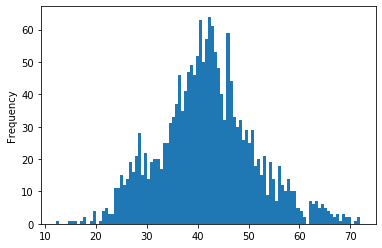

In [19]:
df_evaluate.age.plot(kind='hist', bins=100)

mostly men

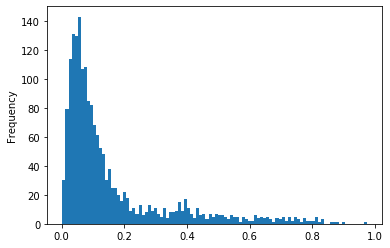

In [20]:
df_evaluate.gender.plot(kind='hist', bins=100)

Clearly, given the name something went wrong

In [24]:
sample = df_evaluate[['name', 'gender', 'age', 'id']].sample(100)

In [27]:
#sample.to_csv('data/sample_eval.csv')

In [26]:
sample

,name,gender,age,id
1554,"Reid, Whitelaw",0.049562,45.960082,https://gallica.bnf.fr/ark:/12148/btv1b53107957h
160,"Bergeret, Jules",0.130214,48.451477,https://gallica.bnf.fr/ark:/12148/btv1b53092170z
1131,"Luigini, Alexandre",0.149626,35.934853,https://gallica.bnf.fr/ark:/12148/btv1b53081671n
701,"Fichel, Benjamin Eugène",0.023955,42.176995,https://gallica.bnf.fr/ark:/12148/btv1b53050626j
1475,"Pline, Joseph",0.050913,37.338769,https://gallica.bnf.fr/ark:/12148/btv1b530659972
...,...,...,...,...
392,"Chevreau, Léon",0.012833,39.189977,https://gallica.bnf.fr/ark:/12148/btv1b530672990
1332,"Mézeray, Cécile",0.477981,34.729284,https://gallica.bnf.fr/ark:/12148/btv1b531345768
657,"Duvernoy, Alphonse",0.031022,54.115696,https://gallica.bnf.fr/ark:/12148/btv1b531173652
680,"Fabrègues, Henri",0.075371,33.435853,https://gallica.bnf.fr/ark:/12148/btv1b53187596p


checking the image, gender predictions seem iffy, but age seems okay! maybe there were not enough old women in the dataset ... 

In [24]:
df_evaluate.iloc[sample.index].id

1880    https://gallica.bnf.fr/ark:/12148/btv1b530659938
1682    https://gallica.bnf.fr/ark:/12148/btv1b53168939s
1624    https://gallica.bnf.fr/ark:/12148/btv1b53141526g
1559    https://gallica.bnf.fr/ark:/12148/btv1b531912725
806     https://gallica.bnf.fr/ark:/12148/btv1b53080133n
1483    https://gallica.bnf.fr/ark:/12148/btv1b53065450c
821     https://gallica.bnf.fr/ark:/12148/btv1b53107908w
542     https://gallica.bnf.fr/ark:/12148/btv1b53100859m
454     https://gallica.bnf.fr/ark:/12148/btv1b53066447f
1457    https://gallica.bnf.fr/ark:/12148/btv1b53152345r
1646    https://gallica.bnf.fr/ark:/12148/btv1b53141463d
1168    https://gallica.bnf.fr/ark:/12148/btv1b53117548b
166     https://gallica.bnf.fr/ark:/12148/btv1b53118862z
603     https://gallica.bnf.fr/ark:/12148/btv1b530796624
1481    https://gallica.bnf.fr/ark:/12148/btv1b53072178x
638     https://gallica.bnf.fr/ark:/12148/btv1b53065518p
989     https://gallica.bnf.fr/ark:/12148/btv1b53118979w
1121    https://gallica.bnf.fr/

## Example of multiple matches or mismatches

In [25]:
age_gender_lables.iloc[1564]

left                                                   165
top                                                    251
right                                                  761
bottom                                                 847
width                                                  596
height                                                 596
gender                                           0.0296453
age                                                45.4266
number                                                   1
id        https://gallica.bnf.fr/ark:/12148/btv1b53107270j
name                                        Ribeyre, Félix
Name: 1564, dtype: object

In [26]:
import matplotlib.pyplot as plt

In [27]:
df_evaluate

,left,top,right,bottom,width,height,gender,age,number,id,name
0,269.0,268.0,748.0,747.0,479.0,479.0,0.116277,47.741472,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53071608k,"Abbatucci, Séverin"
1,433.0,316.0,580.0,463.0,147.0,147.0,0.585720,27.465579,2.0,https://gallica.bnf.fr/ark:/12148/btv1b531622212,"Abbott, Emma"
2,250.0,718.0,403.0,871.0,153.0,153.0,0.377803,40.358822,3.0,https://gallica.bnf.fr/ark:/12148/btv1b53071525p,"Abbéma, Louise"
3,155.0,134.0,872.0,851.0,717.0,717.0,0.104841,44.487285,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53165139q,"Abney, William de Wiveleslie"
4,415.0,184.0,615.0,384.0,200.0,200.0,0.389818,27.194442,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53117510h,"Abott, Bessie"
...,...,...,...,...,...,...,...,...,...,...,...
1881,292.0,351.0,658.0,717.0,366.0,366.0,0.025766,47.032899,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53098072j,Édouard VII
1882,355.0,310.0,596.0,551.0,241.0,241.0,0.033713,45.716630,1.0,https://gallica.bnf.fr/ark:/12148/btv1b53065399p,"Énault, Louis"
1883,288.0,437.0,583.0,732.0,295.0,295.0,0.358721,26.078685,1.0,https://gallica.bnf.fr/ark:/12148/btv1b530664193,"Éon, Charles de Beaumont d'"
1884,310.0,214.0,739.0,643.0,429.0,429.0,0.108013,47.732863,1.0,https://gallica.bnf.fr/ark:/12148/btv1b531271467,"Étex, Antoine"


In [28]:
img = get_image(df_evaluate.id[12])

In [30]:
df_evaluate.id[12]

'https://gallica.bnf.fr/ark:/12148/btv1b53071541q'

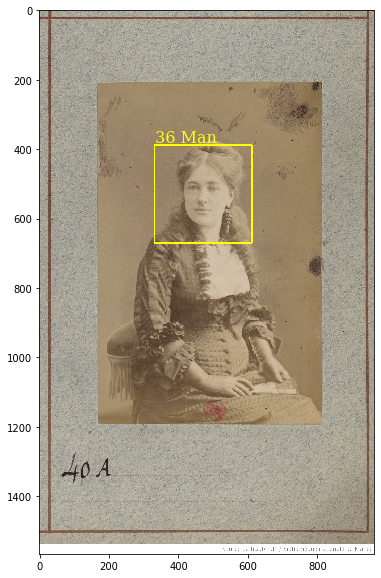

In [31]:
font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'normal',
        'size': 16,
        }
img = get_image(df_evaluate.id[12])

for detect in [age_gender_lables.iloc[12]]:
    gender =  'Woman' if detect['gender'] > .5 else 'Man'
    
    plt.figure(figsize=(10, 10))
    plt.text(detect['left'], 
             detect['top']-10, str(detect['age'])[:2] + ' ' + gender, fontdict=font)
    plt.imshow(cv2.rectangle(img, (int(detect['left']),
                                   int(detect['top'])),
                             (int(detect['right']),
                              int(detect['bottom'])), (255, 255, 0), 3))

## evaluate age annotation

In [73]:
annotation = pd.read_csv('data/sample_eval_updated.csv')

In [74]:
annotation['estimated_age'] = annotation.age

In [75]:
x = 12.6

In [76]:
np.round(x, decimals=-1)

10.0

In [77]:
annotation['age'] = annotation.age.map(lambda x: np.round(x, decimals = -1))
annotation['age'] = annotation.age.map(lambda x: 50 if x > 50 else x)

/Users/lguillain/opt/anaconda3/envs/fdh/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  """Entry point for launching an IPython kernel.


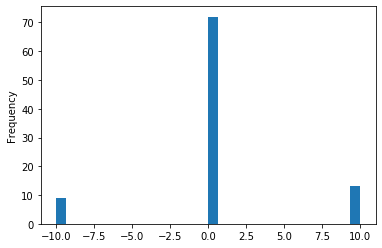

In [78]:
(annotation['age'] - annotation['True age'].astype(float)).plot('hist', bins=30)

In [79]:
annotation['diff'] = annotation['age'] - annotation['True age'].astype(float)

In [80]:
annotation['diff'].value_counts()

 0.0     72
 10.0    13
-10.0     9
Name: diff, dtype: int64

In [81]:
missed = annotation[annotation['diff'] != 0]

In [88]:
((missed['estimated_age'] - missed['True age']).map(abs) > 10).value_counts()

False    21
True      1
dtype: int64